In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Proceso dicotómico

Vamos a ver si el proceso dicotómico es estacionario y ergódico

$$
\left<x(t)x(t+\tau)\right>_{est} = \iint x x' P(x,\tau;x',0) \,dx\,dx' = \frac{1}{2T} \int_{-T}^T x(t)x(t+\tau) \,dt
$$

La probabilidad de sortear un tiempo t es exponencial:

$
\psi(t) = \frac{1}{\lambda} e^{-t/\lambda}
$

Vamos a sortear todos los tiempos y chequear que siguen la distribución exponencial.

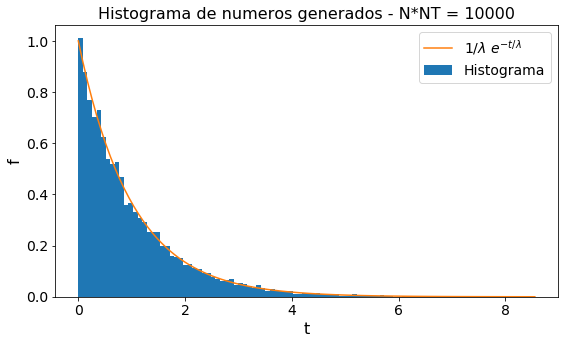

In [122]:
from numpy.random import exponential

N  = 100     # Numero de realizaciones
NT = 100     # Cantidad de pasos
l  = 1       # lambda
# Sorteamos N*NT numeros random que siguen una distribucion exponencial
S = exponential(scale=1/l,size=(N,NT))  # scale: paranetro de escala b=1/lambda

# Vemos si los numero que generamos siguen una dist exponencial
# Generamos la exponencial
tim = linspace(0,max(S.flat),100)
e   = 1/l * exp(-tim/l)

# Graficamos el histograma de los numeros generados y la exponencial
figure(figsize=(9,5))
title("Histograma de numeros generados - N*NT = {}".format(N*NT), fontsize=16)
hist(S.flat,bins=int(sqrt(N*NT)),normed=True, label="Histograma")
plot(tim, e, label="$1/\lambda \ e^{-t/\lambda}$")
xlabel("t", fontsize=16)
ylabel("f", fontsize=16)
tick_params(labelsize=14)
legend(fontsize=14);

Los numeros que generamos siguen bien la dist exponencial

Lo que queremos es que luego de cada tiempo, el numero se vuelva a sortear esto es equivalente a hacer la cumsum de los numeros que acabamos de generar.

Luego vamos a generar el vector de los $X$ con $1$ en los sitios pares y $-1$ en los impares

Con estos dos vectores de tiempos y X vamos a crear la función del proc. dicotómico para cada realización. Por suerte existe una función de interpolación que hace lo que queremos con los datos que tenemos! 


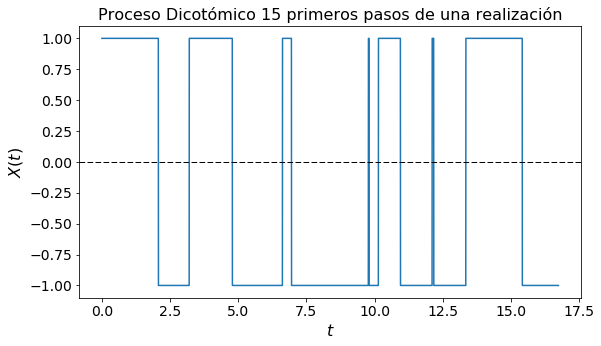

In [123]:
from scipy.interpolate import interp1d

St = cumsum(S,axis=1)   # axis = 1 indica que las sumas se hacen por fila, o sea por realizacion
St = St - St[:,0][:, None]  # y le restamos el primer valor de cada fila respectivamente para que arranque de cero 

# Generamos el vector de X, con 1 en los indices pares y -1 en los impares (o +-D)
D = 1
X  = empty((NT,))
X[::2] = D
X[1::2] = -D

# Interpolamos para cada realizacion la funcion x(t)
Xf = [interp1d(st,X,kind='zero') for st in St]

# Graficamos los primeros n pasos
j = 0   # realizacion j
n = 15  # numero de pasos que vemos

t = arange(St[j][0], St[j][n-1],.001) # generamos un vector de tiempo para la funcion 

figure(figsize=(9,5))
title("Proceso Dicotómico {} primeros pasos de una realización".format(n), fontsize=16)
plot(t, Xf[j](t))

axhline(0, ls="--",c="k",lw=1)
xlabel("$t$", fontsize=16)
ylabel("$X(t)$", fontsize=16)
tick_params(labelsize=14)

Ahora vamos a resolver el promedio temporal

$$
\frac{1}{2T} \int_{-T}^T x(t)x(t+\tau) \,dt
$$

Resuelvo la integral para cada realización y para cada tau. Después promedio todas las integrales para cada $\tau$

In [124]:
from scipy.integrate import quad

# Generamos un vector de taus para hacer los graficos
TAU = linspace(0,5,30)

It = [] # Aca guardamos los promedios de las integrales para cada tau
for tau in TAU:
    I2 = []  # Aca guardamos los valores de las integrales de cada realizacion
    for j,x in enumerate(Xf):
        x2 = lambda q: x(q)*x(q+tau)    # definimos la funcion a integrar
        i2 = quad(x2, St[j][0], St[j][-1]-tau)[0] / (St[j][-1]-tau) # resolvemos la integral
        I2.append(i2)
    It.append(mean(I2))   # Calculamos el promedio de las inegrales de todas las realizaciones

/home/lucas/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/lucas/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


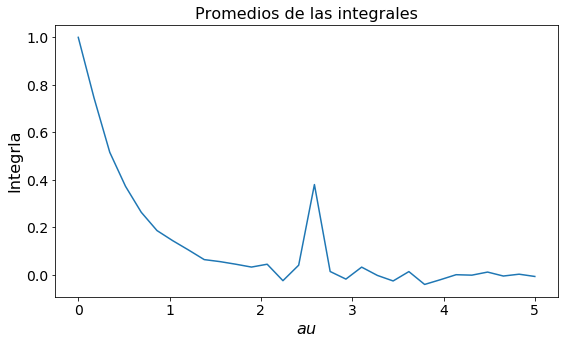

In [126]:
figure(figsize=(9,5))
title("Promedios de las integrales", fontsize=16)
plot(TAU,It)

xlabel(r"$\tau$", fontsize=16)
ylabel("Integral", fontsize=16)
tick_params(labelsize=14)

Ahora calculamos la correlación

$$
\left<x(t)x(t+\tau)\right>_{est}
$$

Vamos a calcular el valor medio $\left<x(t)x(t+\tau)\right>$ para cada $\tau$ promediando el valor de distintos tiempos.

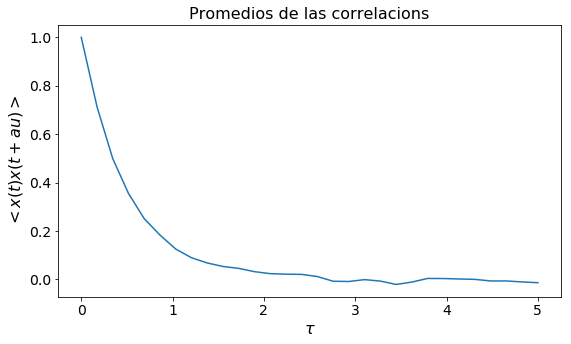

In [136]:
T = linspace(2,min(St[:,-1][:, None])-max(TAU),100)  # Vector de tiempos en donde vamos a calcular los promedios
MM = []  # Aca vamos a guardar los promedios para cada tiempo
for t in T:
    M = []  # Aca guardamos los promedios de x(t)*x(t+tau) para un t y todos los tau
    for tau in TAU:
        m = mean([x(t)*x(t+tau) for x in Xf])  # promediamos para un t y un tau todas las realizaciones
        M.append(m)
    MM.append(M)
E = mean(MM,axis=0)   # calculamos los promedios de todos los tiempos para cada tau

figure(figsize=(9,5))
title("Promedios de las correlacions", fontsize=16)
plot(TAU,E)

xlabel(r"$\tau$", fontsize=16)
ylabel("$<x(t)x(t+\tau)>$", fontsize=16)
tick_params(labelsize=14)

Y ahora comparamos

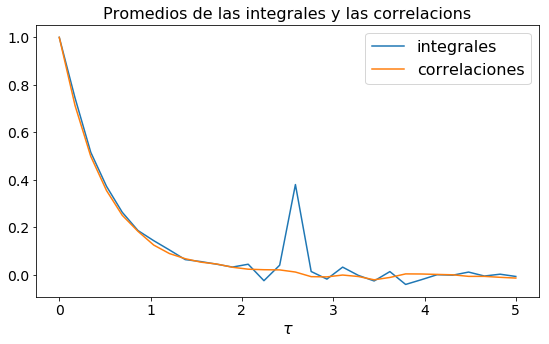

In [137]:
figure(figsize=(9,5))
title("Promedios de las integrales y las correlacions", fontsize=16)
plot(TAU,It, label='integrales')
plot(TAU,E, label='correlaciones')

xlabel(r"$\tau$", fontsize=16)
#ylabel("$<x(t)x(t+\tau)>$", fontsize=16)
tick_params(labelsize=14)
legend(fontsize=16)